In [2]:
import numpy as np
import glob
import os

def merge_npz_to_single_npy(data_dir='data', data_out='Combined_holistic_landmarks_data.npy', labels_out='Combined_holistic_landmarks_labels.npy'):
    npz_files = sorted(glob.glob(os.path.join(data_dir, "holistic_landmarks_*.npz")))

    all_data = []
    all_labels = []

    print(f"Found {len(npz_files)} files to process...\n")

    for i, file in enumerate(npz_files):
        try:
            npz = np.load(file, allow_pickle=True)
            data_batch = np.array(npz['X'], dtype=object)
            labels_batch = np.array(npz['y'])

            print(f"[{i+1}/{len(npz_files)}] Loaded {file} — data shape: {data_batch.shape}, label shape: {labels_batch.shape}")

            all_data.append(data_batch)
            all_labels.append(labels_batch)

        except Exception as e:
            print(f"Error loading file {file}: {type(e).__name__}: {e}")
            break

    print("\nLoaded all files (except failed ones).")
    for i, d in enumerate(all_data):
        print(f" - Batch {i}: shape={d.shape}, dtype={d.dtype}")

    if not all_data or not all_labels:
        print("No valid data found. Exiting.")
        return

    try:
        full_data = np.concatenate(all_data, axis=0)
        full_labels = np.concatenate(all_labels, axis=0)
        print("Data concatenated successfully.")
    except Exception as e:
        print(f"Concatenation failed: {e}")
        return

    print("\n✅ Done saving combined files!")
    print(f"Final Landmarks shape: {full_data.shape}")
    print(f"Final Labels shape: {full_labels.shape}")
    return full_data, full_labels

combined_landmarks, combined_labels = merge_npz_to_single_npy()


Found 43 files to process...

[1/43] Loaded data/holistic_landmarks_Adjectives_1of8.npz — data shape: (5991,), label shape: (5991,)
[2/43] Loaded data/holistic_landmarks_Adjectives_2of8.npz — data shape: (6596,), label shape: (6596,)
[3/43] Loaded data/holistic_landmarks_Adjectives_3of8.npz — data shape: (6636,), label shape: (6636,)
[4/43] Loaded data/holistic_landmarks_Adjectives_4of8.npz — data shape: (5617,), label shape: (5617,)
[5/43] Loaded data/holistic_landmarks_Adjectives_5of8.npz — data shape: (6042,), label shape: (6042,)
[6/43] Loaded data/holistic_landmarks_Adjectives_6of8.npz — data shape: (5848,), label shape: (5848,)
[7/43] Loaded data/holistic_landmarks_Adjectives_7of8.npz — data shape: (5833,), label shape: (5833,)
[8/43] Loaded data/holistic_landmarks_Adjectives_8of8.npz — data shape: (3861,), label shape: (3861,)
[9/43] Loaded data/holistic_landmarks_Animals_1of2.npz — data shape: (7269,), label shape: (7269,)
[10/43] Loaded data/holistic_landmarks_Animals_2of2.npz

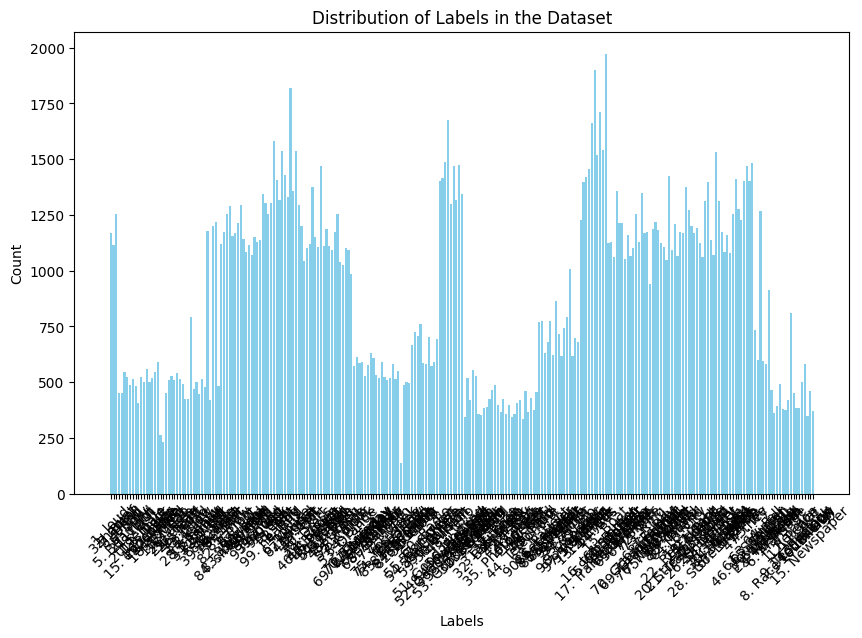

Label Distribution:
Label: 1. loud, Count: 1167
Label: 3. happy, Count: 1113
Label: 2. quiet, Count: 1253
Label: 7. Deaf, Count: 450
Label: 8. Blind, Count: 452
Label: 5. Beautiful, Count: 545
Label: 4. sad, Count: 523
Label: 6. Ugly, Count: 488
Label: 21. tight, Count: 514
Label: 11. rich, Count: 483
Label: 20. female, Count: 406
Label: 15. expensive, Count: 521
Label: 19. male, Count: 500
Label: 13. thick, Count: 558
Label: 16. cheap, Count: 502
Label: 12. poor, Count: 519
Label: 22. loose, Count: 547
Label: 18. curved, Count: 588
Label: 14. thin, Count: 263
Label: 9. Nice, Count: 231
Label: 10. Mean, Count: 453
Label: 17. flat, Count: 511
Label: 27. deep, Count: 527
Label: 29. clean, Count: 508
Label: 30. dirty, Count: 543
Label: 26. hard, Count: 514
Label: 25. soft, Count: 492
Label: 33. dead, Count: 426
Label: 34. alive, Count: 426
Label: 28. shallow, Count: 792
Label: 24. low, Count: 470
Label: 35. heavy, Count: 501
Label: 31. strong, Count: 445
Label: 23. high, Count: 512
Label:

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(combined_labels)

# Get the unique labels and their counts
labels, counts = zip(*label_counts.items())

# Plotting the label distribution
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in the Dataset')
plt.xticks(rotation=45)
plt.show()


# Alternatively, you can print the counts
print("Label Distribution:")
for label, count in label_counts.items():
    print(f'Label: {label}, Count: {count}')

In [4]:
# Check for missing items in landmarks
missing_landmarks = []
for i, landmark in enumerate(combined_landmarks):
    if isinstance(landmark, np.ndarray):
        if np.any(np.isnan(landmark)):
            missing_landmarks.append(i)

# Check for missing labels (None or empty strings)
missing_labels = [i for i, label in enumerate(combined_labels) if label is None or label == '']

# Count missing items
num_missing_landmarks = len(missing_landmarks)
num_missing_labels = len(missing_labels)

# Print the results
print(f'Total missing landmarks: {num_missing_landmarks}')
print(f'Total missing labels: {num_missing_labels}')

# Optionally, find the indices of the missing items
print(f'Indices of missing landmarks: {missing_landmarks}')
print(f'Indices of missing labels: {missing_labels}')

Total missing landmarks: 0
Total missing labels: 0
Indices of missing landmarks: []
Indices of missing labels: []


## Data processing

In [5]:
# Checking the shape of each landmark in x to find inconsistencies
landmark_shapes = [np.array(landmark).shape for landmark in combined_landmarks if isinstance(landmark, list)]

# Identify the unique shapes
unique_shapes = set(landmark_shapes)
print(f"Unique shapes found: {unique_shapes}")

# Fixing inconsistent landmarks by padding or truncating
fixed_landmarks = []
for landmark in combined_landmarks:
    if isinstance(landmark, list):
        landmark_array = np.array(landmark)
        if landmark_array.shape[0] < 543:
            # Pad with zeros if less than 543
            padded = np.pad(landmark_array, ((0, 543 - landmark_array.shape[0]), (0, 0)), mode='constant')
            fixed_landmarks.append(padded)
        elif landmark_array.shape[0] > 543:
            # Truncate if greater than 543
            truncated = landmark_array[:543]
            fixed_landmarks.append(truncated)
        else:
            # Append as is if it has the correct shape
            fixed_landmarks.append(landmark_array)

# Convert the list of fixed landmarks to a numpy array
x_fixed = np.array(fixed_landmarks)
print(f"Fixed landmarks shape: {x_fixed.shape}")

Unique shapes found: {(75, 3), (54, 3), (543, 3), (33, 3), (522, 3), (501, 3)}
Fixed landmarks shape: (227193, 543, 3)


In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

# Normalize the data
scaler = StandardScaler()
landmarks_data_scaled = scaler.fit_transform(x_fixed.reshape(-1, x_fixed.shape[-1]))  # Flatten for scaling
landmarks_data_scaled = landmarks_data_scaled.reshape(x_fixed.shape)  # Reshape back to original
print(f'Scaled landmarks shape: {landmarks_data_scaled.shape}')


Scaled landmarks shape: (227193, 543, 3)


['255Labels_scaler_filename.pkl']

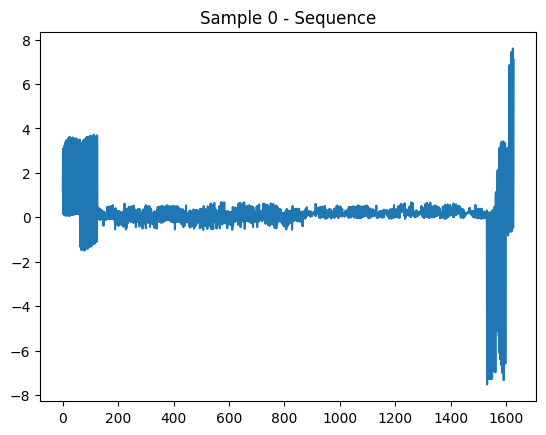

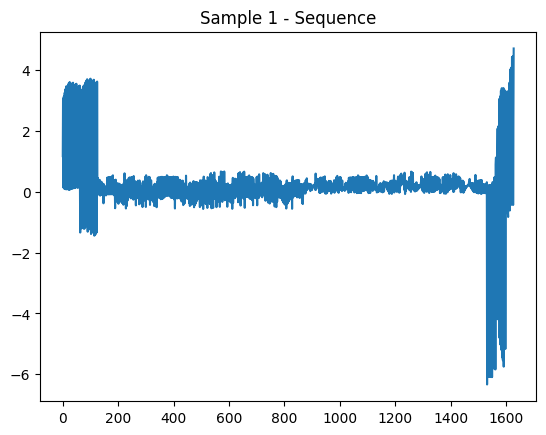

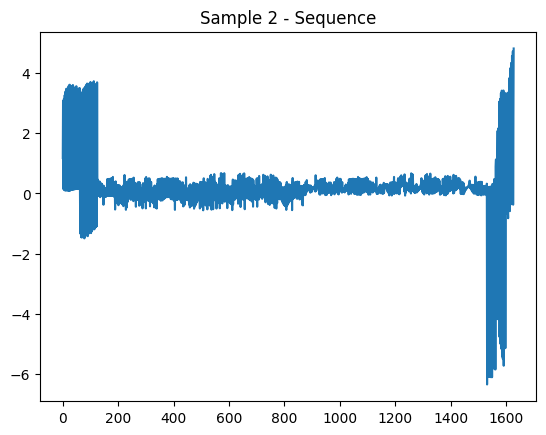

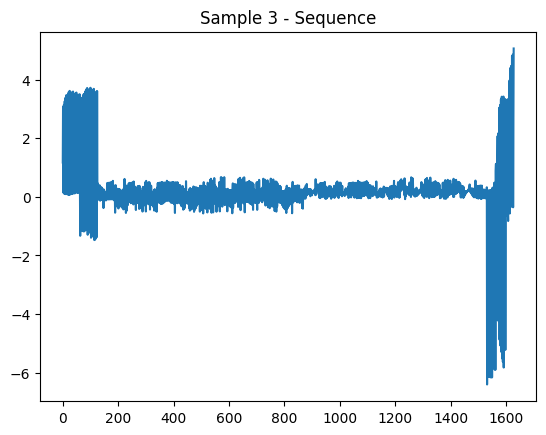

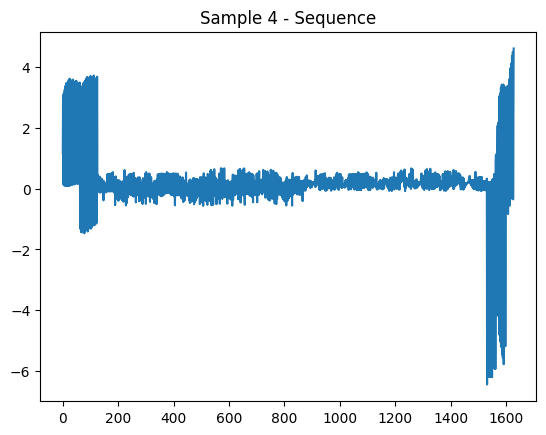

In [7]:
import matplotlib.pyplot as plt

# Check for the sequences with the highest and lowest values
for i in range(5):
    plt.plot(landmarks_data_scaled[i].flatten())
    plt.title(f"Sample {i} - Sequence")
    plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(landmarks_data_scaled, combined_labels, test_size=0.2, random_state=42)

# Print the shapes of the split data
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (181754, 543, 3)
x_test shape: (45439, 543, 3)
y_train shape: (181754,)
y_test shape: (45439,)


## Artifically Creating Data using SMOTE and then Train and Test Split

In [9]:
from imblearn.over_sampling import SMOTE

# Oversample the minority classes using SMOTE (optional)
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_resample(x_train.reshape((x_train.shape[0], -1)), y_train)
x_train_resampled = x_train_resampled.reshape((x_train_resampled.shape[0], x_train.shape[1], x_train.shape[2]))

# Print the shapes of the split data
print(f"x_train shape: {x_train_resampled.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (409020, 543, 3)
x_test shape: (45439, 543, 3)
y_train shape: (409020,)
y_test shape: (45439,)


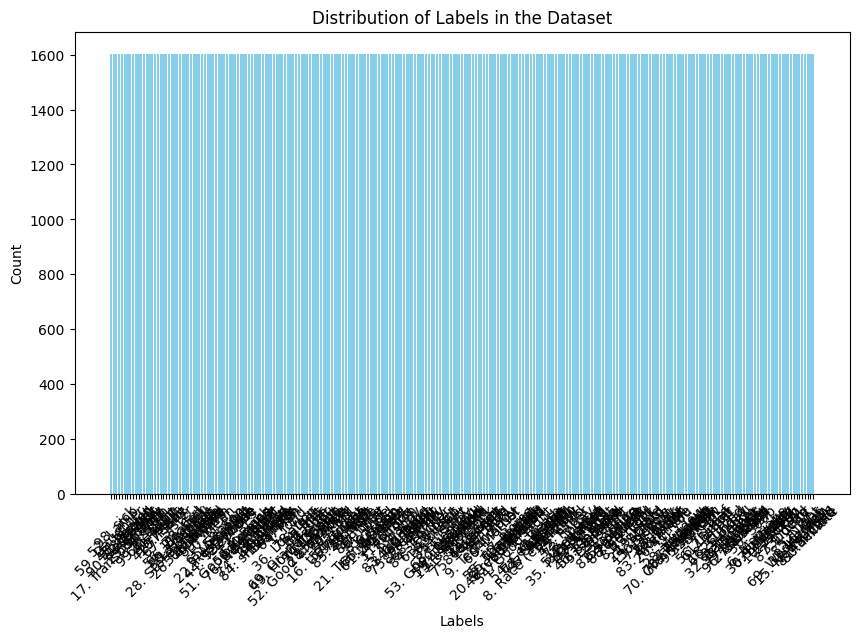

Label Distribution of Y Training:
Label: 59. Daughter, Count: 1604
Label: 52. Lamp, Count: 1604
Label: 98. sick, Count: 1604
Label: 17. Transportation, Count: 1604
Label: 90. Secretary, Count: 1604
Label: 45. Pocket, Count: 1604
Label: 51. Brown, Count: 1604
Label: 82. Player, Count: 1604
Label: 88. cold, Count: 1604
Label: 29. Library, Count: 1604
Label: 86. fast, Count: 1604
Label: 56. Grey, Count: 1604
Label: 96. wet, Count: 1604
Label: 99. healthy, Count: 1604
Label: 9. Train, Count: 1604
Label: 60. Radio, Count: 1604
Label: 21. tight, Count: 1604
Label: 80. Adult, Count: 1604
Label: 42. T-Shirt, Count: 1604
Label: 10. Plane, Count: 1604
Label: 77. Boy, Count: 1604
Label: 67. Sister, Count: 1604
Label: 28. Store or Shop, Count: 1604
Label: 56. Pleased, Count: 1604
Label: 66. Brother, Count: 1604
Label: 30. Hospital, Count: 1604
Label: 78. Girl, Count: 1604
Label: 13. Attack, Count: 1604
Label: 26. University, Count: 1604
Label: 91. Priest, Count: 1604
Label: 31. Temple, Count: 1604

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(y_train_resampled)

# Get the unique labels and their counts
labels, counts = zip(*label_counts.items())

# Plotting the label distribution
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in the Dataset')
plt.xticks(rotation=45)
plt.show()

# Alternatively, you can print the counts
print("Label Distribution of Y Training:")
for label, count in label_counts.items():
    print(f'Label: {label}, Count: {count}')

In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on y_train (since y_train contains all possible labels)
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)  # Apply the same transformation to y_test

# Check the encoded labels
print(f"Encoded y_train: {y_train_encoded[:5]}")  # Print first 5 encoded labels for reference
print(f"Encoded y_test: {y_test_encoded[:5]}")

# Also, let's map the classes for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label Mapping: {label_mapping}")

Encoded y_train: [151 133 251  24 234]
Encoded y_test: [99 82 31  6 88]
Label Mapping: {np.str_('1. Dog'): np.int64(0), np.str_('1. Religion'): np.int64(1), np.str_('1. loud'): np.int64(2), np.str_('10. Energy'): np.int64(3), np.str_('10. Mean'): np.int64(4), np.str_('10. Plane'): np.int64(5), np.str_('11. Car'): np.int64(6), np.str_('11. War'): np.int64(7), np.str_('11. rich'): np.int64(8), np.str_('12. Peace'): np.int64(9), np.str_('12. Truck'): np.int64(10), np.str_('12. poor'): np.int64(11), np.str_('13. Attack'): np.int64(12), np.str_('13. Bicycle'): np.int64(13), np.str_('13. thick'): np.int64(14), np.str_('14. Bus'): np.int64(15), np.str_('14. Election'): np.int64(16), np.str_('14. thin'): np.int64(17), np.str_('15. Boat'): np.int64(18), np.str_('15. Newspaper'): np.int64(19), np.str_('15. expensive'): np.int64(20), np.str_('16. Gun'): np.int64(21), np.str_('16. cheap'): np.int64(22), np.str_('16. train ticket'): np.int64(23), np.str_('17. Transportation'): np.int64(24), np.str_

In [12]:
from collections import Counter

# Check the distribution of the encoded labels
print(f"y_train_encoded distribution: {Counter(y_train_encoded)}")
print(f"y_test_encoded distribution: {Counter(y_test_encoded)}")

y_train_encoded distribution: Counter({np.int64(151): 1604, np.int64(133): 1604, np.int64(251): 1604, np.int64(24): 1604, np.int64(234): 1604, np.int64(109): 1604, np.int64(129): 1604, np.int64(211): 1604, np.int64(228): 1604, np.int64(57): 1604, np.int64(224): 1604, np.int64(144): 1604, np.int64(247): 1604, np.int64(253): 1604, np.int64(233): 1604, np.int64(157): 1604, np.int64(36): 1604, np.int64(204): 1604, np.int64(100): 1604, np.int64(5): 1604, np.int64(193): 1604, np.int64(171): 1604, np.int64(53): 1604, np.int64(146): 1604, np.int64(168): 1604, np.int64(63): 1604, np.int64(195): 1604, np.int64(12): 1604, np.int64(48): 1604, np.int64(236): 1604, np.int64(66): 1604, np.int64(58): 1604, np.int64(201): 1604, np.int64(154): 1604, np.int64(230): 1604, np.int64(0): 1604, np.int64(4): 1604, np.int64(37): 1604, np.int64(166): 1604, np.int64(60): 1604, np.int64(106): 1604, np.int64(150): 1604, np.int64(131): 1604, np.int64(241): 1604, np.int64(38): 1604, np.int64(84): 1604, np.int64(93): 

In [13]:
print(f"x_train shape: {x_train_resampled.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train_encoded.shape}")
print(f"y_test shape: {y_test_encoded.shape}")

x_train shape: (409020, 543, 3)
x_test shape: (45439, 543, 3)
y_train shape: (409020,)
y_test shape: (45439,)


In [14]:
num_classes = len(label_mapping)

## Model Training

In [15]:
from keras.models import Model
from keras.layers import (Input, Bidirectional, LSTM, BatchNormalization, Dropout, 
                          Attention, Flatten, Dense, LeakyReLU, Conv1D, MaxPooling1D)
from keras.optimizers import Adam
from keras.regularizers import l2
input_shape = (x_train_resampled.shape[1], x_train_resampled.shape[2])
input_layer = Input(shape=input_shape)

# First Bidirectional LSTM layer
lstm_out1 = Bidirectional(LSTM(256, return_sequences=True))(input_layer)
lstm_out1 = BatchNormalization()(lstm_out1)
lstm_out1 = Dropout(0.2)(lstm_out1)  # Reduce dropout

# Second Bidirectional LSTM layer
lstm_out2 = Bidirectional(LSTM(256, return_sequences=True))(lstm_out1)
lstm_out2 = BatchNormalization()(lstm_out2)
# Optionally, remove dropout here if needed

# Attention layer
attention_out = Attention()([lstm_out2, lstm_out2])

# Flatten the output of attention
flattened = Flatten()(attention_out)

# Dense layers with reduced L2 regularization
dense1 = Dense(128, kernel_regularizer=l2(0.001))(flattened)
dense1 = LeakyReLU()(dense1)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.3)(dense1)

dense2 = Dense(64, kernel_regularizer=l2(0.001))(dense1)
dense2 = LeakyReLU()(dense2)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.3)(dense2)

# Output layer for classification
output_layer = Dense(num_classes, activation='softmax')(dense2)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


I0000 00:00:1744447213.224484   42896 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21803 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 543, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 543, 512)  │    532,480 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 543, 512)  │      2,048 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 543, 512)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 543, 512)  │  1,574,912 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 543, 512)  │      2,048 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 543, 512)  │          0 │ batch_normalizat… │
│ (Attention)         │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 278016)    │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 35,586,176 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64)        │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 255)       │     16,575 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,723,263 (143.90 MB)

 Trainable params: 37,720,831 (143.89 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [16]:

import tensorflow as tf
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    x_train_resampled,
    y_train_encoded,
    validation_data=(x_test, y_test_encoded),
    epochs=5,
    batch_size=64,
    callbacks = [early_stopping, reduce_lr]
)

if early_stopping.stopped_epoch > 0:
    print(f"Training stopped early at epoch: {early_stopping.stopped_epoch + 1}")
    print(f"Weights restored from epoch: {early_stopping.best_epoch + 1}")
else:
    print("Training completed without early stopping.")


Epoch 1/5


I0000 00:00:1744447218.794479   65058 cuda_dnn.cc:529] Loaded cuDNN version 90300


6391/6391 ━━━━━━━━━━━━━━━━━━━━ 500s 78ms/step - accuracy: 0.0590 - loss: 5.0577 - val_accuracy: 0.2909 - val_loss: 3.1576 - learning_rate: 1.0000e-04
Epoch 2/5
6391/6391 ━━━━━━━━━━━━━━━━━━━━ 497s 78ms/step - accuracy: 0.2887 - loss: 3.1212 - val_accuracy: 0.4445 - val_loss: 2.3892 - learning_rate: 1.0000e-04
Epoch 3/5
6391/6391 ━━━━━━━━━━━━━━━━━━━━ 496s 78ms/step - accuracy: 0.4281 - loss: 2.4730 - val_accuracy: 0.5298 - val_loss: 2.0169 - learning_rate: 1.0000e-04
Epoch 4/5
6391/6391 ━━━━━━━━━━━━━━━━━━━━ 499s 78ms/step - accuracy: 0.5047 - loss: 2.1682 - val_accuracy: 0.5748 - val_loss: 1.8476 - learning_rate: 1.0000e-04
Epoch 5/5
6391/6391 ━━━━━━━━━━━━━━━━━━━━ 501s 78ms/step - accuracy: 0.5566 - loss: 1.9765 - val_accuracy: 0.6057 - val_loss: 1.7341 - learning_rate: 1.0000e-04
Training completed without early stopping.


In [18]:
# Extract training and validation accuracy from the history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Extract training and validation loss from the history (optional)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Print the final training and validation accuracy in the desired format
print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")

Final Training Accuracy: 0.5654
Final Validation Accuracy: 0.6057


1420/1420 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step


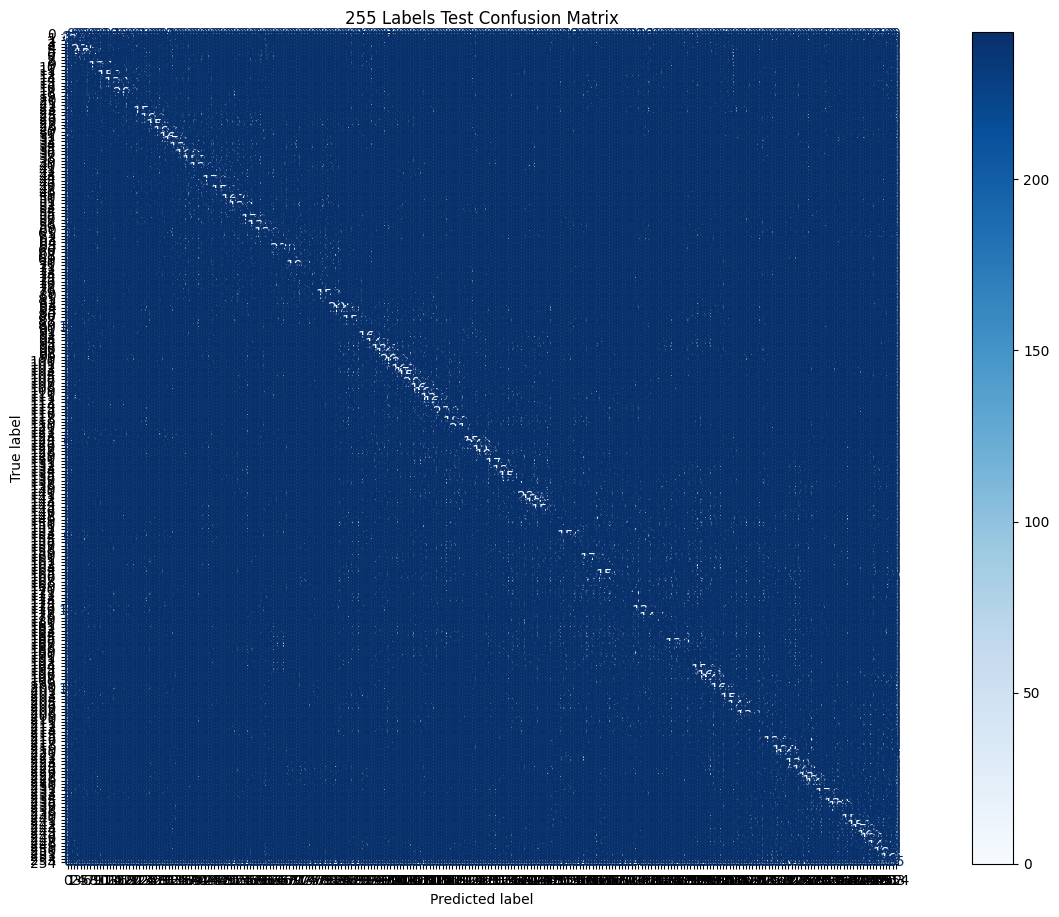

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the trained model (using the model, not history)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Create a figure with a high resolution (e.g., 1080x1920 pixels)
plt.figure(figsize=(19.2, 10.8))  # 1920/100 and 1080/100 for a 100 DPI image

# Display confusion matrix with a larger axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train_encoded))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Plot on the current axis with the desired size

# Customize the plot title
plt.title(f"{len(labels)} Labels Test Confusion Matrix")

# Save the figure in high resolution (1080x1920)
plt.savefig("confusion_matrix_1080x1920.png", dpi=100, bbox_inches='tight')  # You can increase DPI for higher quality
plt.show()

12782/12782 ━━━━━━━━━━━━━━━━━━━━ 274s 21ms/step


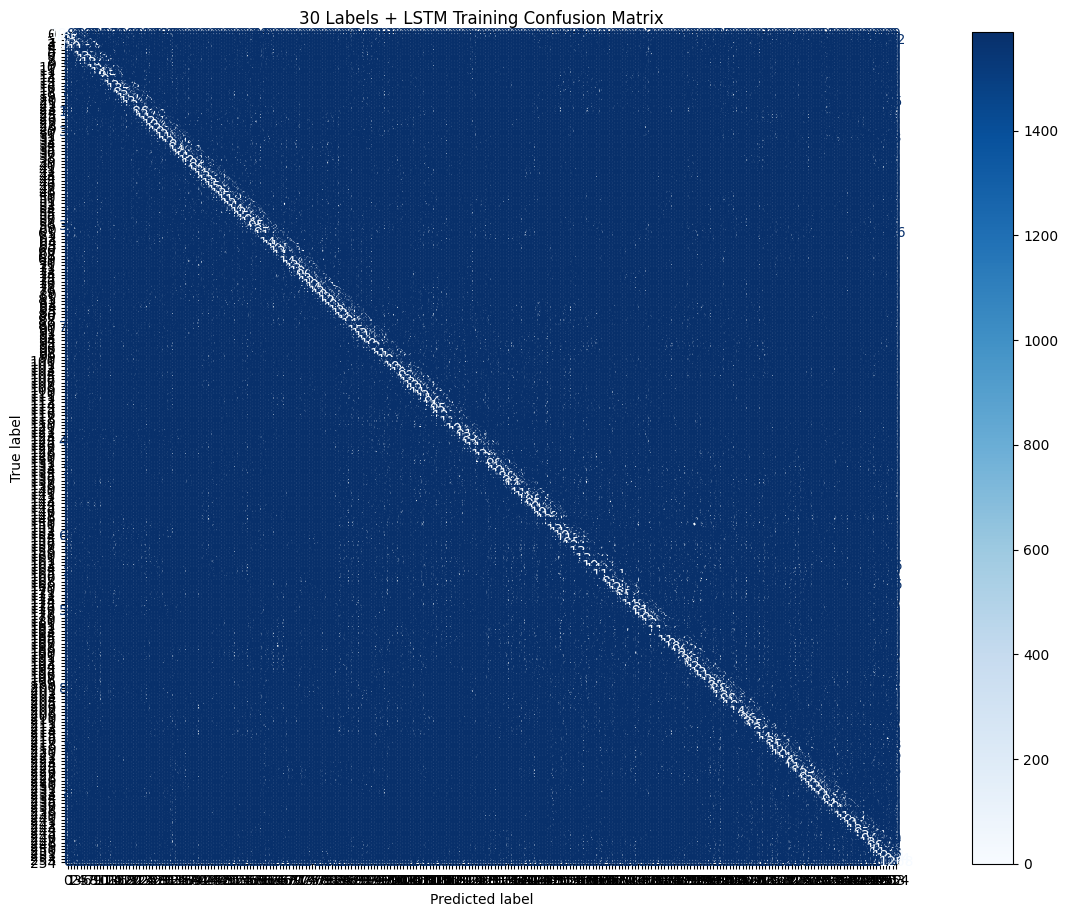

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = model.predict(x_train_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate the confusion matrix
cm = confusion_matrix(y_train_encoded, y_pred_classes)

# Create a figure with a high resolution (e.g., 1080x1920 pixels)
plt.figure(figsize=(19.2, 10.8))  # 1920/100 and 1080/100 for a 100 DPI image

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train_encoded))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Plot on the current larger axis

# Customize the plot
plt.title(f"{len(labels)} Labels + LSTM Training Confusion Matrix")

# Save the figure in high resolution (1080x1920)
plt.savefig("Train_confusion_matrix_1080x1920.png", dpi=100, bbox_inches='tight')  # You can increase DPI for higher quality
plt.show()


In [24]:
# Assuming validation_accuracy is a single numeric value
model_name = f'{len(labels)}_labels' + f"{validation_accuracy[-1]:.4f}"
model.save(f"models/Model_{model_name}.h5")  # Save with .h5 extension
print(f"Model {model_name} was saved.")

Model 255_labels0.6057 was saved.


In [26]:
from tensorflow.keras.models import load_model

loaded_model = load_model(f"models/Model_{model_name}.h5")

In [27]:
loss, accuracy = loaded_model.evaluate(x_test, y_test_encoded, verbose=0)

print(f'Model Loss: {loss:.4f}')
print(f'Model Accuracy: {accuracy:.4f}')

Model Loss: 1.7341
Model Accuracy: 0.6057


In [29]:
from keras.models import Model
from keras.layers import (Input, Bidirectional, LSTM, BatchNormalization, Dropout, 
                          Attention, Flatten, Dense, LeakyReLU)
from keras.regularizers import l2

input_shape = model.input_shape[1:]  # Get shape from loaded model
input_layer = Input(shape=input_shape)

# CPU-friendly LSTM (unroll=True, explicit activations)
lstm_out1 = Bidirectional(LSTM(256, return_sequences=True, activation='tanh',
                               recurrent_activation='sigmoid', unroll=True))(input_layer)
lstm_out1 = BatchNormalization()(lstm_out1)
lstm_out1 = Dropout(0.2)(lstm_out1)

lstm_out2 = Bidirectional(LSTM(256, return_sequences=True, activation='tanh',
                               recurrent_activation='sigmoid', unroll=True))(lstm_out1)
lstm_out2 = BatchNormalization()(lstm_out2)

attention_out = Attention()([lstm_out2, lstm_out2])
flattened = Flatten()(attention_out)

dense1 = Dense(128, kernel_regularizer=l2(0.001))(flattened)
dense1 = LeakyReLU()(dense1)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.3)(dense1)

dense2 = Dense(64, kernel_regularizer=l2(0.001))(dense1)
dense2 = LeakyReLU()(dense2)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.3)(dense2)

output_layer = Dense(model.output_shape[1], activation='softmax')(dense2)

model_cpu = Model(inputs=input_layer, outputs=output_layer)
model_cpu.set_weights(loaded_model.get_weights())

In [31]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model_cpu)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS
]
tflite_model = converter.convert()

with open(f"rpi/{model_name}.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmprk7pmlwi/assets


INFO:tensorflow:Assets written to: /tmp/tmprk7pmlwi/assets


Saved artifact at '/tmp/tmprk7pmlwi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 543, 3), dtype=tf.float32, name='keras_tensor_50')
Output Type:
  TensorSpec(shape=(None, 255), dtype=tf.float32, name=None)
Captures:
  128221361884848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128221361881680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128221361882736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128221361885552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128221361881856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128221361894528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128221361746192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128221361743376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128221361748656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128221361747952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12822133877054

W0000 00:00:1744451207.602266   42896 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744451207.602283   42896 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-12 15:16:47.602420: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprk7pmlwi
2025-04-12 15:16:47.621389: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-12 15:16:47.621398: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmprk7pmlwi
2025-04-12 15:16:48.051463: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-12 15:16:48.768304: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmprk7pmlwi
2025-04-12 15:16:49.397558: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 1795140 microseconds.


In [33]:
import joblib
joblib.dump(scaler, "rpi/scaler.pkl")
joblib.dump(label_encoder, "rpi/label_encoder.pkl")

['rpi/label_encoder.pkl']